# Dataset description
Data for this project is obtained from kaggle. The link to the data is https://www.kaggle.com/code/youben/twitter-sentiment-analysis/data

In [48]:
#Import required library
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import re
import os
import shutil
import string
from matplotlib import pyplot as plt
import pydot 
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from collections import Counter
from tensorflow.keras import losses
from keras import Sequential
from tensorflow.keras.layers import Embedding
from keras.layers import Dense, InputLayer, Dropout, Flatten, BatchNormalization, Conv1D
from keras.layers import GlobalMaxPool1D
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import  pad_sequences
import emoji

Matplotlib is building the font cache; this may take a moment.


# Library description
## Shutil
The shutil in Python is a module used for  several functions mostly to to deal with  file operations  and their collections.It used to copy or  removal files.It resembkes OS module but the only difference is that the OS module lacks functions dealing with file collections
<b>
## Tensorflow library
 It is a library used for machine learnng and deep learning
## String module
 It contains string functions for processing python string
## Pydot
This is an open source graph visualization software

In [2]:
print(tf.__version__)

2.9.1


In [3]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2022-07-16 10:45:39.946064: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory


False

2022-07-16 10:45:39.946097: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-16 10:45:39.946125: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist


In [4]:
# Remove emoji preprocessing code
import emoji

def give_emoji_free_text(text):
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])

    return clean_text

#text = give_emoji_free_text(text)

In [5]:
# Remove url
def rem_url(data_clean):
    p=re.compile(r'\<http.+?\>', re.DOTALL)
    return re.sub(p, '',data_clean)

In [6]:
# Remove punctuations
from string import punctuation
type(punctuation)
my_punctuation = punctuation.replace("'", "")
my_punctuation
def rem_punct(text):
    return text.translate(str.maketrans("", "", my_punctuation))

In [7]:
# Load non_UTF8 data file
#Check the character encoding type
data_path="train.csv"
import chardet
with open(data_path, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result
#From output below, encoding is windows-1252

{'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}

In [8]:
# Load dataset
# data=pd.read_csv("train.csv")
data = pd.read_csv("train.csv",encoding="utf-8")
data["text"]=data['text'].str.lower()
# remove numbers
data['text'] = data['text'].str.replace(r'\d+','')

/tmp/ipykernel_47377/1431470844.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  data['text'] = data['text'].str.replace(r'\d+','')


In [9]:
data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"i`d have responded, if i were going","I`d have responded, if I were going",neutral
1,549e992a42,sooo sad i will miss you here in san diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [10]:
# Check null values
data.isnull().sum()
#Drop nall
data=data.dropna()
# Check after dropping null
data.isnull().sum()

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

In [11]:
data.shape

(27480, 4)

In [12]:
data.dropna(axis=0,how="any",inplace=True)
# Remove wors less than 2
data["word_count"]=data["text"].apply(lambda x:len(str(x)))
mask=data["word_count"]>2

In [13]:
data=data[mask]
data["text"]=(data["text"].
      apply(rem_url).
      apply(give_emoji_free_text).
      apply(rem_punct)
     )

In [14]:
data[["sentiment"]].value_counts()

sentiment
neutral      11117
positive      8582
negative      7781
dtype: int64

In [15]:
data.shape

(27480, 5)

In [16]:
longest_sent=data["word_count"].max()
longest_sent

139

In [17]:
# Remove emoji
def delete_emoji(data):
    emoji= re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U0001F1F2-\U0001F1F4"  # Macau flag
            u"\U0001F1E6-\U0001F1FF"  # flags
            u"\U0001F600-\U0001F64F"
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            u"\U0001f926-\U0001f937"
            u"\U0001F1F2"
            u"\U0001F1F4"
            u"\U0001F620"
            u"\u200d"
            u"\u2640-\u2642"
            "]+", flags=re.UNICODE)

    return emoji.sub(r'',data)


In [18]:
test= pd.read_csv("test.csv",encoding="utf-8")
test["text"]=test["text"].str.lower()
#remove numbers
test['text'] = test['text'].str.replace(r'\d+','')

/tmp/ipykernel_47377/2980684568.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test['text'] = test['text'].str.replace(r'\d+','')


In [19]:
test.head()

,textID,text,sentiment
0,f87dea47db,last session of the day http://twitpic.com/ezh,neutral
1,96d74cb729,shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"recession hit veronique branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/wp - i like it!!,positive


In [20]:
#Preprocessing test data
# Check null values
test.isnull().sum()
#Drop nall
test=test.dropna()
# Check after dropping null
test.isnull().sum()
test.dropna(axis=0,how="any",inplace=True)
# Remove wors less than 2
test["word_count"]=test["text"].apply(lambda x:len(str(x)))
mask=test["word_count"]>2


test=test[mask]
test["text"]=(test["text"].
      apply(rem_url).
      apply(rem_punct).
      apply(give_emoji_free_text)
     )
# example to not remove numbers


In [21]:
test["sentiment"].value_counts()

neutral     1430
positive    1103
negative    1001
Name: sentiment, dtype: int64

In [22]:
longest_sent_test=test["word_count"].max()
longest_sent_test

138

In [23]:

#Tokenizing.
# Splitting sentense in words 
words=3000
token=Tokenizer(num_words=words,lower=True,oov_token="unk")
token.fit_on_texts(data["text"].tolist())


In [24]:
print(token.texts_to_sequences(["I`d have responded, if I were going"]))

[[2, 376, 17, 1, 69, 2, 119, 46]]


In [25]:
X=data["text"].tolist()
y=data["sentiment"].tolist()

In [26]:
# Label encoding
le=LabelEncoder()
y_label=le.fit_transform(y)
print(y_label[0:5])
y_label=np.array(tf.keras.utils.to_categorical(y_label))
y_label[0:5]

y_test=test["sentiment"].tolist()
y_test=le.fit_transform(y_test)
y_test=np.array(tf.keras.utils.to_categorical(y_test))


[1 0 0 0 0]


In [27]:
# Output is the seuence of indexes

In [28]:
# Spliting
X_train, X_valid, y_train, y_valid = train_test_split(X, y_label, test_size=0.2, random_state=42,stratify=y)


In [29]:
# Spliting
#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_valid, test_size=0.1, random_state=42,stratify=y)


In [30]:
#Padding add 0 to sebtenses with less words in the set
X_train=np.array(token.texts_to_sequences(X_train),dtype="object")
X_valid=np.array(token.texts_to_sequences(X_valid),dtype="object")
X_test=np.array(token.texts_to_sequences(test["text"].tolist()),dtype="object")
                 

In [31]:
X_test

array([list([93, 1157, 13, 4, 23, 1]),
       list([1, 10, 238, 59, 902, 1, 1, 1, 31, 1717, 11, 2141, 1, 1]),
       list([1, 436, 1, 1, 131, 91, 3, 1506, 98, 849, 269, 5, 782]), ...,
       list([2, 57, 58, 8, 334, 6, 160, 485, 10, 1, 224, 1, 111, 387, 3, 544, 1, 1]),
       list([1, 58, 10, 41, 142, 566, 446, 123, 24, 62, 2, 43, 41, 1004]),
       list([1, 1, 2253, 371, 2790, 1])], dtype=object)

In [32]:
X_train[0]

[2082, 1, 15, 1790, 118, 25, 65, 1]

In [33]:
#Padding
X_train=pad_sequences(X_train,padding="post",maxlen=145)
X_valid=pad_sequences(X_valid,padding="post",maxlen=145)
X_test=pad_sequences(X_test,padding="post",maxlen=145)

In [34]:
X_valid[0][0:5]

array([ 606,    7,  432, 1840,   20], dtype=int32)

In [35]:
test_labels=le.transform(test["sentiment"].tolist())
y_test=np.array(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

['negative', 'neutral', 'positive']

In [36]:
X_train

array([[2082,    1,   15, ...,    0,    0,    0],
       [ 510,  491,    4, ...,    0,    0,    0],
       [   6, 1472,   10, ...,    0,    0,    0],
       ...,
       [  35,   34,    8, ...,    0,    0,    0],
       [ 411,  411,   84, ...,    0,    0,    0],
       [  85,   49,   24, ...,    0,    0,    0]], dtype=int32)

In [37]:
train_ds=tf.data.Dataset.from_tensor_slices((X_train,y_train))
valid_ds=tf.data.Dataset.from_tensor_slices((X_valid,y_valid))
test_ds=tf.data.Dataset.from_tensor_slices((X_test,y_test))

In [38]:
for x,y in train_ds:
    print(x,y)
    break

tf.Tensor(
[2082    1   15 1790  118   25   65    1    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0], shape=(145,), dtype=int32) tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)


In [39]:
max_features=15000
embedding_die=64
sequence_length=145
model=Sequential()
model.add(Embedding(max_features+1,embedding_die,input_length=sequence_length,\
                   embeddings_regularizer=regularizers.l2(0.0005)))
model.add(Conv1D(filters=128,kernel_size=3,activation="relu",\
                 kernel_regularizer=regularizers.l2(0.0005),\
                 bias_regularizer=regularizers.l2(0.0005)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(3,activation="sigmoid",\
                 kernel_regularizer=regularizers.l2(0.0005),\
                 bias_regularizer=regularizers.l2(0.0005)))
model.summary()
model.compile(loss=losses.CategoricalCrossentropy(from_logits=True),optimizer="Nadam",metrics=["categorical_accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 145, 64)           960064    
                                                                 
 conv1d (Conv1D)             (None, 143, 128)          24704     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 985,155
Trainable params: 985,155
Non-trainable params: 0
__________________________________________________

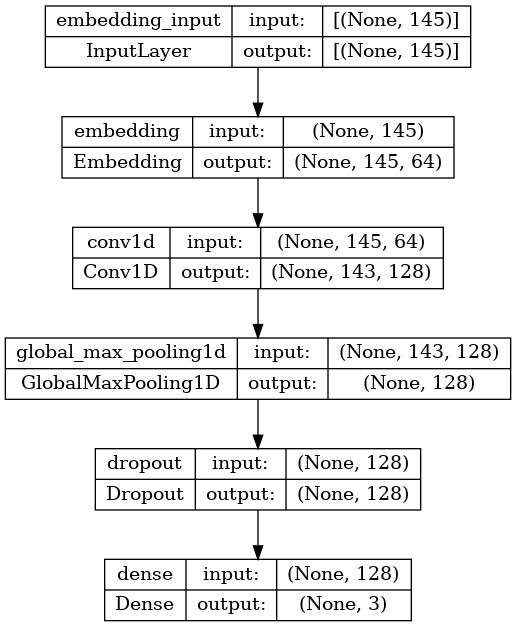

In [40]:
#Plot CNN layers
#! pip install pydot
#! sudo apt install graphviz
tf.keras.utils.plot_model(model,"multi_input_output.png",show_shapes=True)

In [41]:
#! pip install pydot
#! sudo apt install graphviz

In [42]:
epochs=10
history=model.fit(train_ds.shuffle(max_features).batch(128),\
                  epochs=epochs,\
                  validation_data=valid_ds.batch(1128),\
                  verbose=1)

Epoch 1/10


/home/bonface/miniconda3/envs/tensorflow/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


172/172 [==============================] - ETA: 0s - loss: 1.0411 - categorical_accuracy: 0.5420

2022-07-16 10:46:14.292779: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 82587648 exceeds 10% of free system memory.
2022-07-16 10:46:14.479518: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 82587648 exceeds 10% of free system memory.
2022-07-16 10:46:14.682244: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 82587648 exceeds 10% of free system memory.
2022-07-16 10:46:14.869243: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 82587648 exceeds 10% of free system memory.


172/172 [==============================] - 20s 109ms/step - loss: 1.0411 - categorical_accuracy: 0.5420 - val_loss: 0.8141 - val_categorical_accuracy: 0.6812
Epoch 2/10


2022-07-16 10:46:15.070553: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 72044544 exceeds 10% of free system memory.


172/172 [==============================] - 18s 102ms/step - loss: 0.7882 - categorical_accuracy: 0.7012 - val_loss: 0.7658 - val_categorical_accuracy: 0.7078
Epoch 3/10
172/172 [==============================] - 18s 104ms/step - loss: 0.7483 - categorical_accuracy: 0.7243 - val_loss: 0.7629 - val_categorical_accuracy: 0.7158
Epoch 4/10
172/172 [==============================] - 17s 101ms/step - loss: 0.7311 - categorical_accuracy: 0.7354 - val_loss: 0.7611 - val_categorical_accuracy: 0.7193
Epoch 5/10
172/172 [==============================] - 18s 102ms/step - loss: 0.7183 - categorical_accuracy: 0.7405 - val_loss: 0.7688 - val_categorical_accuracy: 0.7163
Epoch 6/10
172/172 [==============================] - 18s 102ms/step - loss: 0.7076 - categorical_accuracy: 0.7494 - val_loss: 0.7703 - val_categorical_accuracy: 0.7171
Epoch 7/10
172/172 [==============================] - 18s 103ms/step - loss: 0.7005 - categorical_accuracy: 0.7586 - val_loss: 0.7808 - val_categorical_accuracy: 0.71

# Plot training and validation accuracy

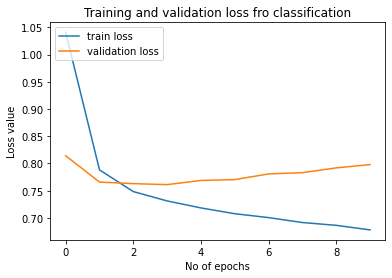

In [51]:
plt.plot(history.history["loss"],label="train loss")
plt.plot(history.history["val_loss"],label="validation loss")
plt.title("Training and validation loss fro classification")
plt.ylabel("Loss value")
plt.xlabel("No of epochs")
plt.legend(loc="upper left")
plt.show()




# Plot Categorical Accuracy


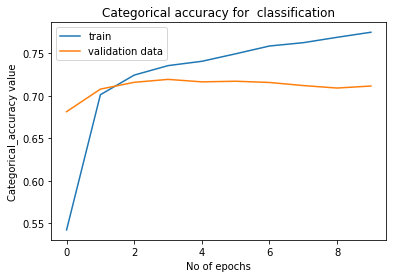

In [52]:
plt.plot(history.history["categorical_accuracy"],label="train")
plt.plot(history.history["val_categorical_accuracy"],label="validation data")
plt.title("Categorical accuracy for  classification")
plt.ylabel("Categorical_accuracy value")
plt.xlabel("No of epochs")
plt.legend(loc="upper left")
plt.show()




In [56]:
# Save the mode
model.save("twitter_analysis_model1") # saving the model


INFO:tensorflow:Assets written to: twitter_analysis_model1/assets


INFO:tensorflow:Assets written to: twitter_analysis_model1/assets
